In [2]:
# CNN(Convolutional Neural Network) - Fashion MNIST Dataset

# 딥러닝 CNN 아키텍처 
# Feature Extractor(Conv>Pool>Conv>Pool) -> Fully-Connected(Flatten) -> Classification(Linear>Dropout->Linear)

In [3]:
# import, GPU 설정
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('pytorch version : ', torch.__version__, ', device : ', DEVICE)

pytorch version :  2.7.1+cu118 , device :  cuda


In [4]:
# MNIST Dataset 다운로드

# train
train_dataset = datasets.FashionMNIST(root='.\\data\\FashionMNIST_data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)
# test
test_dataset = datasets.FashionMNIST(root='.\\data\\FashionMNIST_data',
                               train=False,
                               transform=transforms.ToTensor(),
                               download=True)

In [5]:
# MNIST Dataset 확인
print(len(train_dataset), len(test_dataset))

60000 10000


In [6]:
# MNIST Dataset 데이터 분리 - train 85% : validation 15%
train_dataset_size = int(len(train_dataset) * 0.85) # train 85%
validation_dataset_size = int(len(train_dataset) * 0.15) # validation 15%
train_dataset, validation_dataset = random_split(dataset=train_dataset,
                                                 lengths=[train_dataset_size, validation_dataset_size])

In [7]:
# MNIST Dataset 데이터 분리 확인
print(len(train_dataset), len(validation_dataset), len(test_dataset))

51000 9000 10000


In [8]:
# batch, dataloader 생성
BATCH_SIZE = 32

# train
train_dataset_loader = DataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True)

# validation
validation_dataset_loader = DataLoader(dataset=validation_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

# test
test_dataset_loader = DataLoader(dataset=test_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=False)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


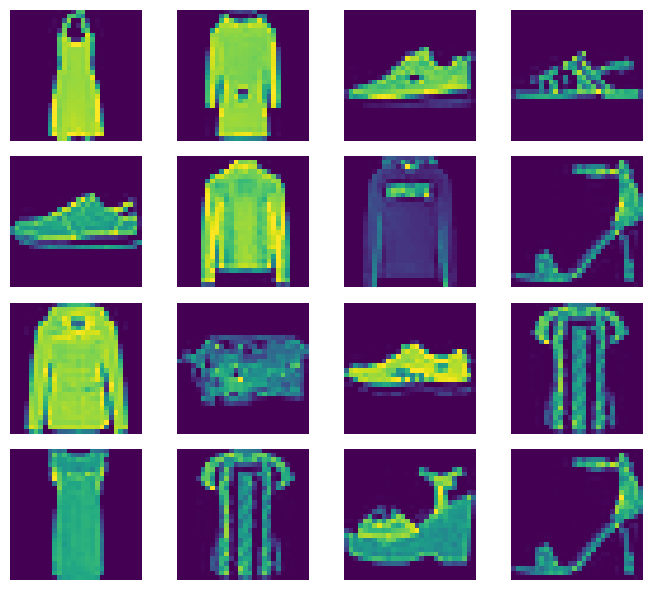

In [9]:
# MNIST Dataset 1개 배치 데이터 확인
images, labels = next(iter(train_dataset_loader))

# labels map 생성
labels_map = { v:k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

plt.figure(figsize=(7,6))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    
    plt.subplot(cols, rows, i)
    plt.imshow(torch.permute(img, (1,2,0)))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [10]:
# CNN Model
# 딥러닝 CNN 아키텍처
# Feature Extractor(Conv>Pool>Conv>Pool) -> Fully-Connected(Flatten) -> Classification(Linear>Dropout->Linear)
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        
        self.pooling = nn.MaxPool2d(kernel_size=2,
                                    stride=2)
        
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 10)

        self.dropout25 = nn.Dropout(p=0.25)
        self.dropout50 = nn.Dropout(p=0.5)
    
    def forward(self, x):
        # 패딩이 적용되었기 때문에 컨볼루션층을 통과한 데이터는 크기는 변하지 않고 필터 개수와 동일하게 출력채널 개수만 변함
        # 맥스풀링층을 통과한 데이터는 1/2로 바뀌지만 채널 개수는 변하지 않음
        # conv1, data shape = (H, W, C) = (28, 28, 1)
        x = self.conv1(x) # (28, 28, 1)
        x = torch.relu(x) # (28, 28, 32)
        x = self.pooling(x) # (28, 28, 32)
        x = self.dropout25(x) # (14, 14, 32)
        # conv2
        x = self.conv2(x) # (14, 14, 32)
        x = torch.relu(x) # (14, 14, 64)
        x = self.pooling(x) # (14, 14, 64)
        x = self.dropout25(x) # (7, 7, 64)
        # (높이,너비,채널)3차원 텐서이므로 완전연결층(Fully-Connected)과 연결을 위해 view() 명령어를 이용해서 3차원 텐서를 1차원 vector로 만들어 주는 역할
        # view(-1, 벡터크기) 이용해서 배치차원은 유지되고 3차원 텐서는 1차원 벡터로 변환됨
        x = x.view(-1, 7 * 7 * 64)

        # Linear
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout50(x)
        
        x = self.fc2(x)

        return x

In [11]:
# Model 객체 생성
model = CNNModel().to(DEVICE)

# loss function
loss_function = nn.CrossEntropyLoss() # Softmax() 함수 포함되어 있음

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Model 정보
print(model)

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout25): Dropout(p=0.25, inplace=False)
  (dropout50): Dropout(p=0.5, inplace=False)
)


In [12]:
# Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0
    train_correct = 0
    train_total = 0
    total_train_batch = len(dataloader)

    for images, labels in dataloader:
        # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
        x_train = images.to(DEVICE)
        y_train = labels.to(DEVICE)

        # 모델 예측값 게산
        outputs = model(x_train)

        # 손실함수값 계산
        loss = loss_function(outputs, y_train)

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item()
        train_total += y_train.size(0)
        train_correct += (torch.argmax(outputs, 1) == y_train).sum().item()
    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [13]:
# Model evaluate 함수
def model_evaluate(dataloader, model, loss_function, optimizer):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            # 오차역전파
            # optimizer.zero_grad() # 미분 연산 초기화
            # loss.backward() # 미분 연산
            # optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, 1) == y_val).sum().item()
        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [14]:
# Model test 함수
def model_test(dataloader, model):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)

        for images, labels in dataloader:
            # 처음 크기는 (batch_size, 1, 28, 28) -> (batch_size, 784) 1차원 벡터로 변환
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            # 오차역전파
            # optimizer.zero_grad() # 미분 연산 초기화
            # loss.backward() # 미분 연산
            # optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, 1) == y_test).sum().item()
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        return test_avg_loss, test_avg_accuracy

In [15]:
# Model 학습 
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader,
                                                     model=model,
                                                     loss_function=loss_function,
                                                     optimizer=optimizer)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy)
    )

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

epoch :  01 train loss =  0.577360 , train acc =  78.786275 val loss =  0.361929 , val acc =  86.422222
epoch :  02 train loss =  0.393948 , train acc =  85.635294 val loss =  0.306957 , val acc =  88.222222
epoch :  03 train loss =  0.340190 , train acc =  87.558824 val loss =  0.270445 , val acc =  89.822222
epoch :  04 train loss =  0.311271 , train acc =  88.386275 val loss =  0.245388 , val acc =  90.833333
epoch :  05 train loss =  0.286933 , train acc =  89.515686 val loss =  0.236890 , val acc =  91.122222
epoch :  06 train loss =  0.273454 , train acc =  90.121569 val loss =  0.228064 , val acc =  91.377778
epoch :  07 train loss =  0.262433 , train acc =  90.370588 val loss =  0.221875 , val acc =  91.722222
epoch :  08 train loss =  0.249442 , train acc =  90.752941 val loss =  0.212515 , val acc =  91.888889
epoch :  09 train loss =  0.236181 , train acc =  91.319608 val loss =  0.221763 , val acc =  91.477778
epoch :  10 train loss =  0.233077 , train acc =  91.490196 val 

In [16]:
# Test Dataset 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader,
            model=model)

(0.22159121721721114, 92.27)

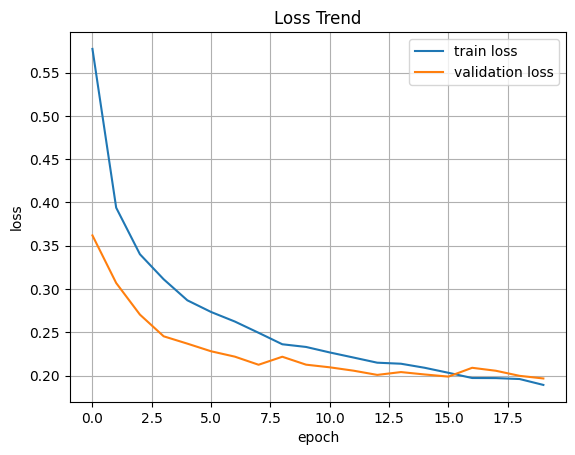

In [17]:
# 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()


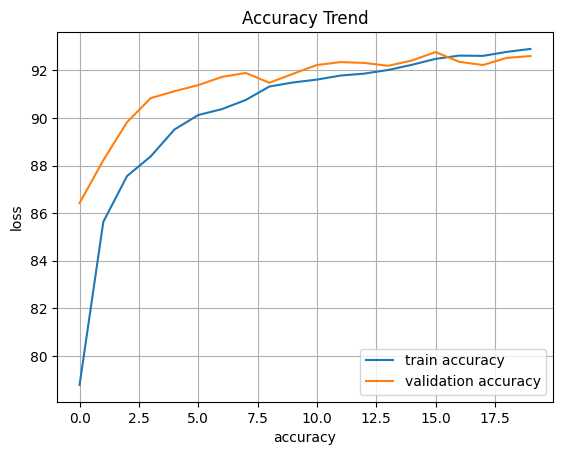

In [18]:
# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('accuracy')
plt.ylabel('loss')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()


In [19]:
# Save the model checkpoint
torch.save(model.state_dict(), '.\\models\\model_cnn_fashion_mnist.ckpt')